In [1]:
import os 
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from loguru import logger

from models.cluster import KMeansClusterModel
from models.cluster import HierarchicalCluster

from utils.load import load_sequences, load_metadata
from utils.pitch import extract_pitch_based_features
from utils.pitch import plot_pca_variance
from utils.pitch import plot_clusters, plot_dendrogram

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [ ]:
def main():

    # extract sequences
    sequences_df = load_sequences("data/sequences_old")
    records = []

    # generate feature

    for idx, row in sequences_df.iterrows():
        seq = row['sequence']
        features = extract_pitch_based_features(seq, max_interval=12)

        records.append({
            "id": idx,
            "features": features,
            "path": row['path']
        })

    features_df = pd.DataFrame(records, index=[r['id'] for r in records])
    features_df.sort_index(inplace=True)

    # apply pca

    X = np.vstack(features_df["features"].values)

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=0.95, random_state=42)   # keep 95% of variance
    X_pca = pca.fit_transform(X_std)
    logger.info(f"PCA reduced from {X.shape[1]} -> {X_pca.shape[1]} dimensions "
                f"({pca.explained_variance_ratio_.sum():.2%} variance kept)")

    plot_pca_variance(pca)

    model = KMeansClusterModel(n_clusters=4, max_iters=300, random_state=42)
    model.fit(X_pca)
    labels = model.labels_

    # Attach to your features_df
    features_df["cluster"] = labels
    logger.info(f"Cluster distribution:\n{features_df['cluster'].value_counts()}")
    plot_clusters(X_pca, labels, dim=3, title="K-Means Cluster on PCA Features")

2025-11-11 20:02:43.150 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences_old with extension .npy
Loading sequences: 323it [00:00, 3651.08it/s]
2025-11-11 20:02:43.276 | SUCCESS  | utils.load:load_sequences:81 - Loaded 323 sequences from data/sequences_old


,id,features,path
bach_2186_vs6_1,bach_2186_vs6_1,"[0.0, 0.13976194237515868, 0.0, 0.182321556793...",data/sequences_old/bach/bach_2186_vs6_1_seq.npy
bach_2191_vs6_5,bach_2191_vs6_5,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",data/sequences_old/bach/bach_2191_vs6_5_seq.npy
bach_2195_fugue3,bach_2195_fugue3,"[0.06136894637629212, 0.13036181786324358, 0.0...",data/sequences_old/bach/bach_2195_fugue3_seq.npy
bach_2196_prelude3,bach_2196_prelude3,"[0.0775582343458745, 0.06252035698133399, 0.01...",data/sequences_old/bach/bach_2196_prelude3_seq...
bach_2198_fugue22,bach_2198_fugue22,"[0.08191712246788672, 0.11506932978478719, 0.0...",data/sequences_old/bach/bach_2198_fugue22_seq.npy


2025-11-15 16:44:31.247 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences_old with extension .npy
Loading sequences: 323it [00:00, 3317.99it/s]
2025-11-15 16:44:31.348 | SUCCESS  | utils.load:load_sequences:81 - Loaded 323 sequences from data/sequences_old
2025-11-15 16:44:31.703 | INFO     | __main__:main:31 - PCA reduced from 169 -> 85 dimensions (95.15% variance kept)


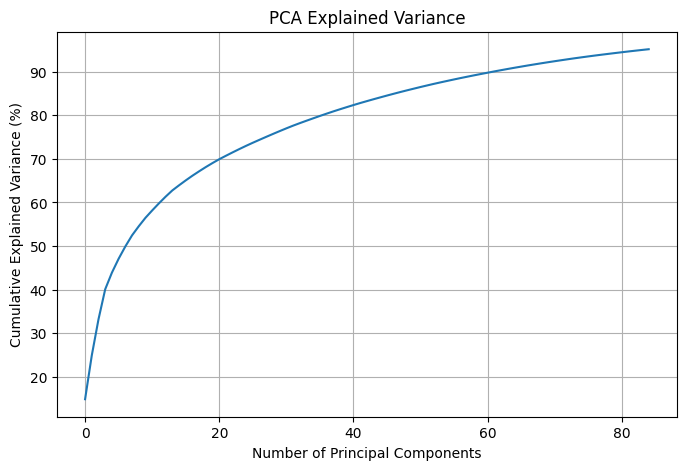

2025-11-15 16:44:31.739 | INFO     | __main__:main:42 - Cluster distribution:
cluster
2    120
3    110
0     90
1      3
Name: count, dtype: int64


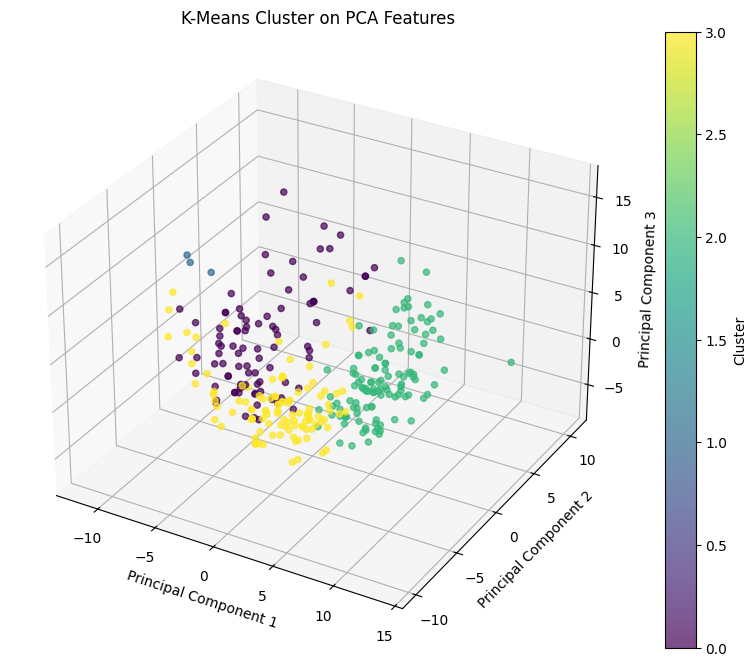

In [9]:
updated_features = main()

In [6]:
updated_features.head(5)

,id,features,path,features_transformed,cluster
0,bach_2186_vs6_1,"[0.0, 0.13976194237515868, 0.0, 0.182321556793...",data/sequences_old/bach/bach_2186_vs6_1_seq.npy,"[10.374165024273584, 7.194099938006979, 8.0201...",2
1,bach_2191_vs6_5,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",data/sequences_old/bach/bach_2191_vs6_5_seq.npy,"[9.088814621179433, 7.558539716170844, 11.4830...",2
2,bach_2195_fugue3,"[0.06136894637629212, 0.13036181786324358, 0.0...",data/sequences_old/bach/bach_2195_fugue3_seq.npy,"[-4.836732388843908, 7.703081504436189, 3.6135...",1
3,bach_2196_prelude3,"[0.0775582343458745, 0.06252035698133399, 0.01...",data/sequences_old/bach/bach_2196_prelude3_seq...,"[-2.899810051200674, 9.473178215737779, 5.2691...",1
4,bach_2198_fugue22,"[0.08191712246788672, 0.11506932978478719, 0.0...",data/sequences_old/bach/bach_2198_fugue22_seq.npy,"[-3.902279241025601, 6.321395969378976, 3.7973...",1


# Hieracial Cluserting

In [14]:
def hier_clustering():
    records = []
    sequences_df = load_sequences("data/sequences")

    for idx, row in sequences_df.iterrows():
        seq = row["sequence"]

        features = extract_pitch_based_features(seq, max_interval=12)
        
        records.append({
            "id": idx,
            "features": np.array(features, dtype=float),
            "path": row["path"]
        })

    features_df = pd.DataFrame(records, index=[r["id"] for r in records])
    features_df.sort_index(inplace=True)

    X = np.vstack(features_df["features"].values)

    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_std)

    logger.info(f"PCA reduced from {X.shape[1]} → {X_pca.shape[1]} dims "
                f"({pca.explained_variance_ratio_.sum():.2%} variance kept)")

    plot_pca_variance(pca)

    model = HierarchicalCluster(n_clusters=4)
    model.fit(X_pca)
    labels = model.labels_

    features_df["cluster"] = labels
    logger.info(f"Cluster distribution:\n{features_df['cluster'].value_counts()}")

    plot_clusters(X_pca, labels, dim=2, title="Hierarchical Clusters on PCA Features")

    plot_dendrogram(X_pca, method="ward", title="Dendrogram of PCA Features")

    return features_df

2025-11-15 16:46:21.377 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences with extension .npy
Loading sequences: 91it [00:00, 1150.77it/s]
2025-11-15 16:46:21.461 | SUCCESS  | utils.load:load_sequences:81 - Loaded 91 sequences from data/sequences
2025-11-15 16:46:21.567 | INFO     | __main__:hier_clustering:30 - PCA reduced from 169 → 58 dims (95.23% variance kept)


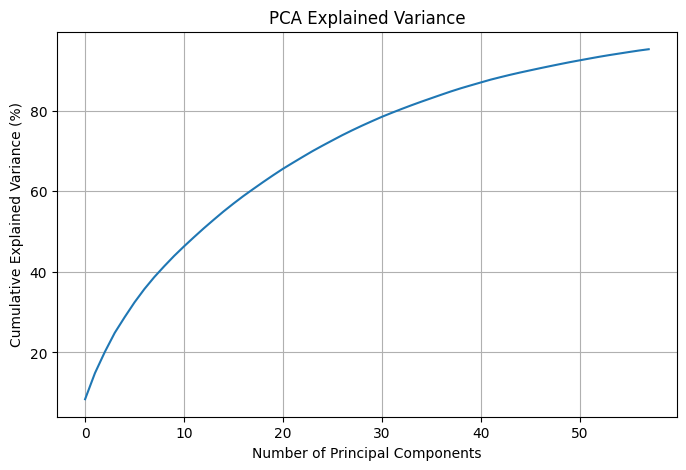

2025-11-15 16:46:22.487 | INFO     | __main__:hier_clustering:40 - Cluster distribution:
cluster
3    88
0     1
1     1
2     1
Name: count, dtype: int64


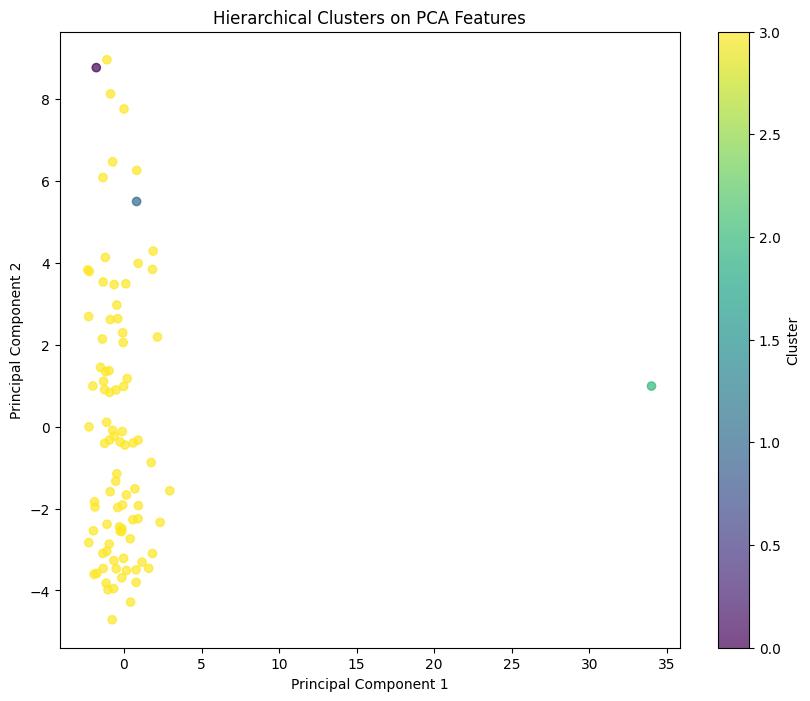

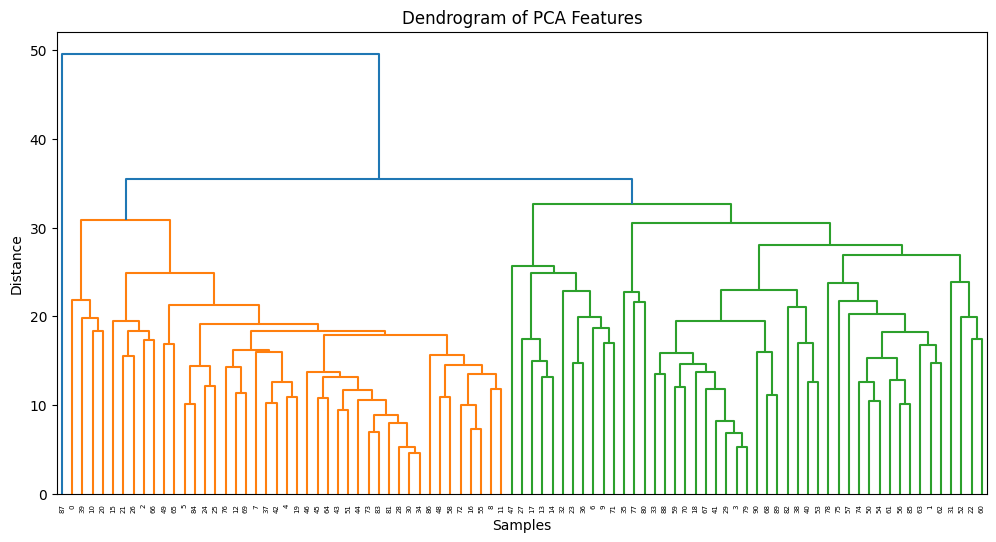

In [15]:
feature_df = hier_clustering()

## investegate outlier

In [16]:
metadata_df = load_metadata("data/metadata/movies_metadata.csv")

for cid in [0, 1, 2]:
    row = feature_df[feature_df["cluster"] == cid].iloc[0]
    print(f"\nCluster {cid}:")
    id = row["id"]
    print(metadata_df.loc[id, 'title'])



Cluster 0:
E.T. the Extra-Terrestrial

Cluster 1:
Batman

Cluster 2:
Avatar
